In [1]:
 !pip install torchxrayvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 53.4 MB/s eta 0:00:00:00:0100:01


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchxrayvision as xrv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import skimage.transform

import wandb

In [3]:
wandb.init(project="Densenet",
           entity="omarammar0"
          )

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [5]:
dataset_path = '/kaggle/input/knee-dataset2/Dataset knee'
class_labels = sorted(os.listdir(dataset_path))

images = []
labels = []

for label, class_label in enumerate(class_labels):
    class_path = os.path.join(dataset_path, class_label)
    for image_name in os.listdir(class_path):
        images.append(image_name)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

df = pd.DataFrame({'image_id': images, 'label': labels})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_val, test = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)
train, validation = train_test_split(train_val, test_size=0.1, stratify=train_val['label'], random_state=42)

train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test = test.reset_index(drop=True)
Cases = {i: class_label for i, class_label in enumerate(class_labels)}


In [6]:
Cases = {}
for i in range(len(class_labels)):
    Cases[i] = class_labels[i]
print(Cases)

print('----------------------------------------------------')
print("Number of Images in training : " , len(train))
print("Number of Images in validation : " , len(validation))
print("Number of Images in testing : " , len(test))
print("Total Images : " , len(train)+len(validation)+len(test))
print('----------------------------------------------------')


x = ["Train", "Test", "Validation"]
data = [train , test , validation]
c = 0
for i in data:
    print("----- {} -----".format(x[c]))
    for j in Cases:
        print("{}: {}".format(Cases[j],len(i[i["label"] == j])))
    c += 1

{0: 'Normal', 1: 'Osteopenia', 2: 'Osteoporosis'}
----------------------------------------------------
Number of Images in training :  481
Number of Images in validation :  54
Number of Images in testing :  60
Total Images :  595
----------------------------------------------------
----- Train -----
Normal: 150
Osteopenia: 169
Osteoporosis: 162
----- Test -----
Normal: 19
Osteopenia: 21
Osteoporosis: 20
----- Validation -----
Normal: 17
Osteopenia: 19
Osteoporosis: 18


In [7]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(dataset_path, Cases[self.df.iloc[idx, 1]], self.df.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        img = image.convert('L')

        if self.transform:
            img = self.transform(img)

        img = img * 2048 - 1024
        label = self.df.iloc[idx, 1]
        return img, label

In [8]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = CustomDataset(train, transform=train_transform)
validation_dataset = CustomDataset(validation, transform=test_transform)
test_dataset = CustomDataset(test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)


In [9]:
model = xrv.models.DenseNet(weights="densenet121-res224-all")
model.op_threshs = None
model.classifier = torch.nn.Linear(1024, 3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.classifier.parameters(), lr=0.1)

criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience= 3)


If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


In [10]:
EPOCHS = 100
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    running_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(validation_loader.dataset)
    val_accuracy = 100 * correct_val / total_val
    scheduler.step(val_loss)


    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {running_loss:.4f}, Validation Loss: {val_loss:.4f},Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%, Learning Rate: {current_lr}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        wandb.save('best_model.pth')

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "training_loss": running_loss,
        "training_accuracy": train_accuracy,
        "validation_loss": val_loss,
        "validation_accuracy": val_accuracy,
        "learning_rate": current_lr
    })

Epoch 1/100, Training Loss: 1.5611, Validation Loss: 1.2035,Training Accuracy: 49.27%, Validation Accuracy: 57.41%, Learning Rate: 0.1
Epoch 2/100, Training Loss: 1.2020, Validation Loss: 0.7562,Training Accuracy: 60.91%, Validation Accuracy: 68.52%, Learning Rate: 0.1
Epoch 3/100, Training Loss: 1.2200, Validation Loss: 1.0211,Training Accuracy: 57.80%, Validation Accuracy: 66.67%, Learning Rate: 0.1
Epoch 4/100, Training Loss: 1.0376, Validation Loss: 0.7649,Training Accuracy: 61.75%, Validation Accuracy: 70.37%, Learning Rate: 0.1
Epoch 5/100, Training Loss: 0.8297, Validation Loss: 0.8244,Training Accuracy: 65.49%, Validation Accuracy: 68.52%, Learning Rate: 0.1
Epoch 6/100, Training Loss: 0.8623, Validation Loss: 0.7114,Training Accuracy: 66.74%, Validation Accuracy: 75.93%, Learning Rate: 0.1
Epoch 7/100, Training Loss: 0.7164, Validation Loss: 0.7200,Training Accuracy: 70.27%, Validation Accuracy: 75.93%, Learning Rate: 0.1
Epoch 8/100, Training Loss: 0.6850, Validation Loss: 0.

In [11]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: ', 100 * correct / total, '%')

Accuracy:  75.0 %


In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [13]:
def plot_images(images, labels, classes, normalize=False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min=image_min, max=image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [14]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

images, labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)

In [19]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    ax.set_title("Best Model DenseNet")
    plt.xticks(rotation=20)


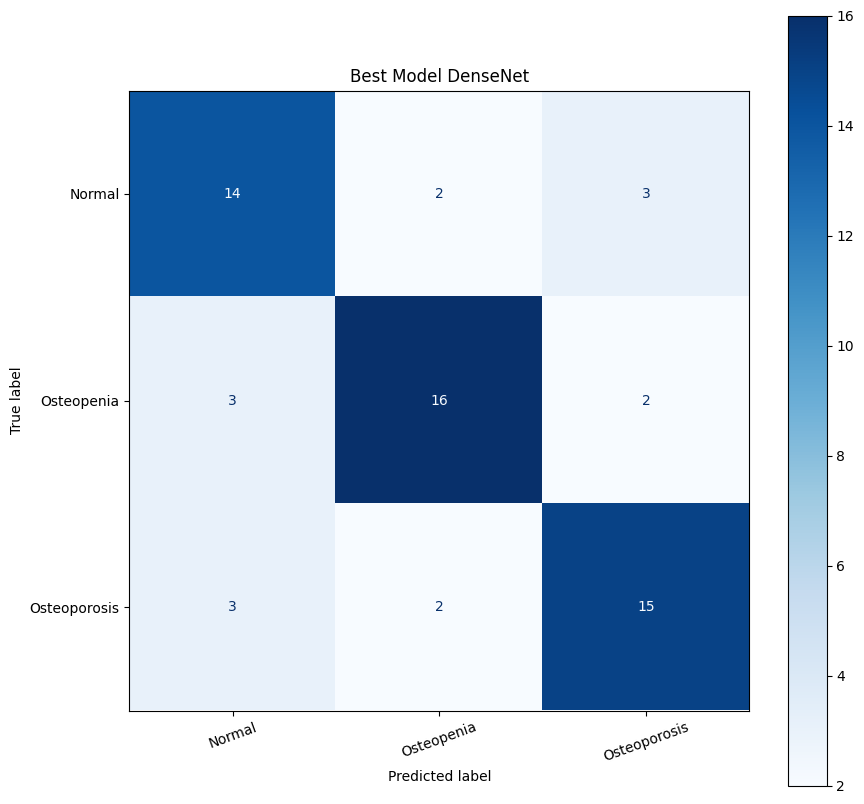

In [20]:
plot_confusion_matrix(labels, pred_labels, class_labels)
corrects = torch.eq(labels, pred_labels)
